# MVA2018 - TP1 - Word Embeddings and BoW Classification

Welcome to an "ipython notebook", a simple python environment where you can code and prototype easily.

In this lab, we will talk about:
* word2vec: word embeddings and their properties
* average of word embeddings for sentences (sentence similarity)
* Document classification with bag-of-words: classifying IMDB movie reviews

Start by downloading all the text data we will need:

https://s3.amazonaws.com/senteval/imdb/data.zip (tar -xvf data.zip to extract it)


You will also need to have the following packages:

* gensim
* nltk
* sklearn

In [1]:
# In python you have "packages" that you import (numpy, scikit-learn, keras, torch .)
import os
import logging
reload(logging)
logging.basicConfig(format='%(asctime)s %(levelname)s:%(message)s', level=logging.INFO, datefmt='%I:%M:%S')
import random
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# load scikit-learn
import sklearn

# load gensim package
import gensim

C:\Anaconda3\envs\py27\lib\site-packages\gensim\utils.py:1167: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")
02:13:52 INFO:'pattern' package not found; tag filters are not available for English


## I - POS tagging and parsing visualization

You can visualize the POS tagging and the Parsing outputs of the Stanford tool here:
http://nlp.stanford.edu:8080/parser/index.jsp

## II - Word2vec: word embeddings

In this part, we are going to play with word2vec embeddings.
For simplicity, we will use the **gensim** python package which provides an implementation of the word2vec algorithm and some nice functionalities.

We are going to use the **"data/text8"** corpus to train word2vec.

In [2]:
# Load the "text8" text corpus
fname = 'data/text8'
assert os.path.isfile(fname), 'there is no file %s' % (fname)
text8 = gensim.models.word2vec.Text8Corpus('data/text8')

# let's visualize some of the text in the text8 corpus
for i, doc in enumerate(text8):
    
    print i, ' '.join(doc[0:200])
    if i > 0:
        break

0 anarchism originated as a term of abuse first used against early working class radicals including the diggers of the english revolution and the sans culottes of the french revolution whilst the term is still used in a pejorative way to describe any act that used violent means to destroy the organization of society it has also been taken up as a positive label by self defined anarchists the word anarchism is derived from the greek without archons ruler chief king anarchism as a political philosophy is the belief that rulers are unnecessary and should be abolished although there are differing interpretations of what this means anarchism also refers to related social movements that advocate the elimination of authoritarian institutions particularly the state the word anarchy as most anarchists use it does not imply chaos nihilism or anomie but rather a harmonious anti authoritarian society in place of what are regarded as authoritarian political structures and coercive economic institut

**REMINDER**

* Word2vec is a tool. "SkipGram" is one of the two methods of Word2vec (along with "CBOW").

* Skipgram consists of an **input lookup table**, and a **classifier** (which itself consists of a projection W and a softmax function).

* The algorithm will iterate over the text8 corpus, "encode" a word using the lookup table, and predict their surrounding words using the classifier.

* The parameters of the lookup table and the classifier will be jointly trained to solve this task (using SGD and backpropagation).

* At the very end, the word embeddings are contained in the lookup table (a matrix of size V*dim).

In [3]:
# Learn a word2vec model on text8 using the gensim package
w2v_model = gensim.models.word2vec.Word2Vec(text8, size=100)

02:15:25 INFO:collecting all words and their counts
02:15:25 INFO:PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
02:15:31 INFO:collected 253854 word types from a corpus of 17005207 raw words and 1701 sentences
02:15:31 INFO:Loading a fresh vocabulary
02:15:32 INFO:min_count=5 retains 71290 unique words (28% of original 253854, drops 182564)
02:15:32 INFO:min_count=5 leaves 16718844 word corpus (98% of original 17005207, drops 286363)
02:15:32 INFO:deleting the raw counts dictionary of 253854 items
02:15:32 INFO:sample=0.001 downsamples 38 most-common words
02:15:32 INFO:downsampling leaves estimated 12506280 word corpus (74.8% of prior 16718844)
02:15:32 INFO:estimated required memory for 71290 words and 100 dimensions: 92677000 bytes
02:15:32 INFO:resetting layer weights
02:15:33 INFO:training model with 3 workers on 71290 vocabulary and 100 features, using sg=0 hs=0 sample=0.001 negative=5 window=5
02:15:34 INFO:EPOCH 1 - PROGRESS: at 7.11% examples, 881512 words/s

** REMINDER **

* **"Words that appear in similar contexts will have similar meaning"**
* **"You shall know a word by the company it keeps"**

are the intuitions behind word2vec and the resulting word similarities that we will see right now.

In [4]:
# Words that are similar are close in the sense of the cosine similarity.
sim = w2v_model.wv.similarity('woman', 'man')
print 'Printing word similarity between "woman" and "man" : {0}'.format(sim)

Printing word similarity between "woman" and "man" : 0.741788853981


In [5]:
# And words that appear in the same context have similar word embeddings.
w2v_model.wv.most_similar(['man'])

02:17:08 INFO:precomputing L2-norms of word weight vectors


[(u'woman', 0.7417888641357422),
 (u'girl', 0.6623306274414062),
 (u'creature', 0.6308012008666992),
 (u'gentleman', 0.5680364966392517),
 (u'person', 0.5646349787712097),
 (u'mortal', 0.5627669095993042),
 (u'demon', 0.559777021408081),
 (u'stranger', 0.5596663951873779),
 (u'god', 0.556771993637085),
 (u'boy', 0.5541359186172485)]

In [6]:
# Compositionality and structure in word2vec space
w2v_model.wv.most_similar(positive=['woman', 'king'], negative=['man'])

[(u'queen', 0.662168025970459),
 (u'prince', 0.6023272275924683),
 (u'princess', 0.5994733572006226),
 (u'elizabeth', 0.5850202441215515),
 (u'throne', 0.5816978216171265),
 (u'son', 0.5786405801773071),
 (u'mary', 0.5732231140136719),
 (u'daughter', 0.5693716406822205),
 (u'empress', 0.5647904872894287),
 (u'wife', 0.5614184141159058)]

## Visualization with PCA

In what follows, we visualize the word embedding space using a **Principal Component Analysis (PCA) with 2 principal components**. After projecting the word vectors from 100D space to a 2D space, we can plot them, and **visualize the nearest neighbors of any word in the vocabulary**.

In [9]:
# this contains the matrix of embeddings (V, dim)
print(w2v_model.syn1neg.shape)

# Fit the PCA-2 with sklearn !!
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
pca.fit(w2v_model.syn1neg)

C:\Anaconda3\envs\py27\lib\site-packages\ipykernel\__main__.py:2: DeprecationWarning: Call to deprecated `syn1neg` (Attribute will be removed in 4.0.0, use self.trainables.syn1neg instead).
  from ipykernel import kernelapp as app


(71290L, 100L)


C:\Anaconda3\envs\py27\lib\site-packages\ipykernel\__main__.py:7: DeprecationWarning: Call to deprecated `syn1neg` (Attribute will be removed in 4.0.0, use self.trainables.syn1neg instead).


PCA(copy=True, iterated_power='auto', n_components=2, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

In [10]:
"""
This function takes a model, a pca object and a word as input.
It computes the nearest neighbors of the word using the "model".
Then it projects all their word vectors into the 2D space using the object "pca".
Finally, it plots the input query and its nearest neighbors.
"""

def plot_similar_word(model, pca, word):
    
    arr = np.empty((0,model.vector_size), dtype='f')
    word_labels = [word]

    # get close words
    close_words = model.wv.similar_by_word(word)
    
    # add the vector for each of the closest words to the array
    arr = np.append(arr, np.array([model.wv[word]]), axis=0)
    for wrd_score in close_words:
        wrd_vector = model.wv[wrd_score[0]]
        word_labels.append(wrd_score[0])
        arr = np.append(arr, np.array([wrd_vector]), axis=0)
        
    # find tsne coords for 2 dimensions
    np.set_printoptions(suppress=True)
    Y = pca.transform(arr)

    x_coords = Y[:, 0]
    y_coords = Y[:, 1]
    # display scatter plot
    plt.figure(figsize=(8, 6), dpi=80)
    plt.scatter(x_coords, y_coords)

    for label, x, y in zip(word_labels, x_coords, y_coords):
        plt.annotate(label, xy=(x, y), xytext=(0, 0), textcoords='offset points', fontsize=18)
    plt.xlim(x_coords.min()-0.2, x_coords.max()+0.2)
    plt.ylim(y_coords.min()-0.2, y_coords.max()+0.2)
    plt.title('Nearest neighbors visualization of the word "%s"' % word)

    plt.show()

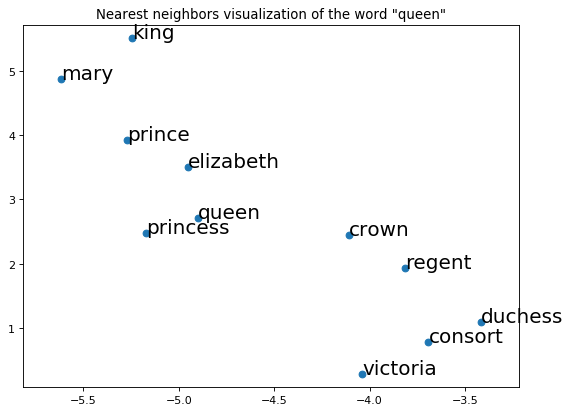

In [11]:
plot_similar_word(w2v_model, pca, 'queen')
# Note the vectors (prince - princess) and (king - queen) !

## III - Average of word2vec

In this part, we will create sentence embeddings using word embeddings.

We are going to use a set of sentences from **"data/sentences.txt"**.

In [12]:
# Load the sentences (= captions of images)
sentences = []
with open('data/sentences.txt') as f:
    for i, line in enumerate(f):
        sent = line.rstrip().split()
        sentences.append(sent)
print('Found %s sentences' % len(sentences))

Found 150736 sentences


Now that we've loaded the sentences from the file, let's encode them using the **average of the word embeddings**.

In [13]:
# Encode the sentences
sentemb = []
for sent in sentences:
    sentemb.append(np.mean([w2v_model.wv[w] for w in sent if w in w2v_model.wv], axis=0))
sentemb = np.vstack(sentemb)
print('Encoded %s sentences (dim = %s)' % (sentemb.shape[0], sentemb.shape[1]))

Encoded 150736 sentences (dim = 100)


Let's try and get the nearest neighbors for sentences

In [14]:
# Get nearest neighbor of a sentence
def get_nearest_sentences(sentences, sentemb, idx, K=5):
    keys = sentemb.copy()
    keys = keys / np.linalg.norm(keys, 2, 1)[:, None]  # normalize embeddings
    scores = keys[idx].dot(keys.T)  # dot-product of normalized vector = cosine similarity
    
    idxs = scores.argsort()[::-1][1:K+1]
    
    print('Top-%s NNs of \n"%s"\n\n' % (K, ' '.join(sentences[idx])))
    for i, idx in enumerate(idxs):
        print('%s) %s' % (i + 1, ' '.join(sentences[idx])))

In [15]:
query_idx = random.randint(0, len(sentences))
get_nearest_sentences(sentences, sentemb, query_idx, K=5)

Top-5 NNs of 
"a child peeks his head out from some flowers ."


1) a dog sticking his head out from under some gray stairs .
2) a baby peeking out from inside her cot
3) a toddler child peaks his head up from behind a large brown package .
4) watching a child from behind as their long hair flies out .
5) a bearded man taking a stocking down from his mantle .


In [16]:
"""
This function takes a model, a pca object and a sentence embedding.
It computes the nearest neighbors of the word using the "model".
Then it projects all their word vectors into the 2D space using the object "pca".
Finally, it plots the input query and its nearest neighbors.
"""

def plot_similar_sent(model, pca, sent):
    
    query = np.mean([model.wv[w] for w in sent.split() if w in model.wv], axis=0)
    
    arr = np.empty((0,model.vector_size), dtype='f')
    word_labels = [sent]

    # get close words
    close_words = model.wv.similar_by_vector(query, topn=20)
    
    # add the vector for each of the closest words to the array
    arr = np.append(arr, np.array([query]), axis=0)
    for wrd_score in close_words:
        wrd_vector = model.wv[wrd_score[0]]
        word_labels.append(wrd_score[0])
        arr = np.append(arr, np.array([wrd_vector]), axis=0)
        
    # find tsne coords for 2 dimensions
    np.set_printoptions(suppress=True)
    Y = pca.transform(arr)

    x_coords = Y[:, 0]
    y_coords = Y[:, 1]
    # display scatter plot
    plt.figure(figsize=(10, 8), dpi=80)
    plt.scatter(x_coords, y_coords)

    for label, x, y in zip(word_labels, x_coords, y_coords):
        if label == sent:
            plt.annotate(label, xy=(x, y), xytext=(0, 0), textcoords='offset points', fontsize=24, weight="bold")
        else:
            plt.annotate(label, xy=(x, y), xytext=(0, 0), textcoords='offset points', fontsize=14)
    plt.xlim(x_coords.min()-0.2, x_coords.max()+0.2)
    plt.ylim(y_coords.min()-0.2, y_coords.max()+0.2)
    plt.title('Nearest neighbors visualization of the sentence "%s"' % sent)

    plt.show()

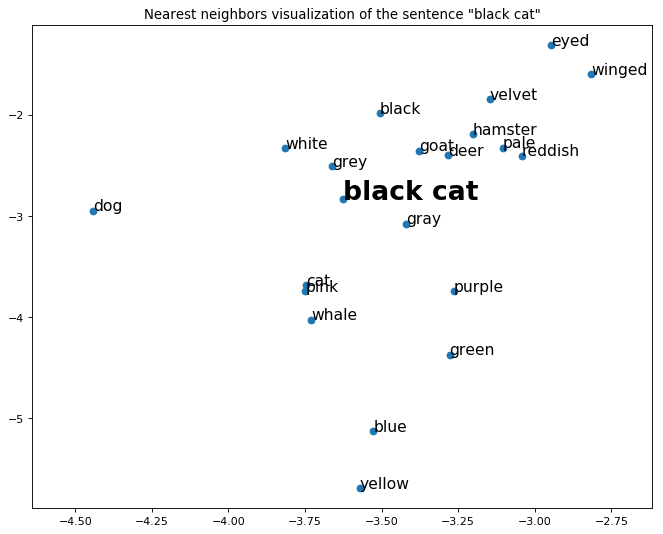

In [17]:
plot_similar_sent(w2v_model, pca, 'black cat')

# IV - Text classification with bag-of-words

In this part, we are going to perform classification of IMDB movie reviews using the word vectors and the bag-of-words representation.

## IV.1) Let's load and tokenize the IMDB dataset

In [18]:
def load_imdb():
    imdb = {'train': {'S': [], 'X': [], 'y': []},
            'valid': {'S': [], 'X': [], 'y': []},
            'test': {'S': [], 'X': [], 'y': []}}
    for split in ['train', 'valid', 'test']:
        with open('data/%s.txt' % split) as f:
            for line in f:
                y, sent = line.rstrip().split('\t', 1)
                assert y in ['pos', 'neg']
                imdb[split]['S'].append(sent)
                imdb[split]['y'].append(1 if y == 'pos' else 0)

                assert len(imdb[split]['y']) == len(imdb[split]['S'])
            print('Loaded %s %s IMDB samples' % (len(imdb[split]['y']), split.upper()))
    return imdb

In [19]:
imdb = load_imdb()

Loaded 25000 TRAIN IMDB samples
Loaded 12500 VALID IMDB samples
Loaded 12500 TEST IMDB samples


In [20]:
print('REVIEW: \n%s\n' % imdb['train']['S'][0])
print('LABEL: %s' % imdb['train']['y'][0])

REVIEW: 
This film has great acting, great photography and a very strong story line that really makes you think about who you are, how you define yourself, how you fit in, whether you accept to play a role or break free... There already are excellent comments dealing with these aspects. I want to comment on the formal setting of the film. Basically, it's two people on a roof. There is unity of place and time, with 2 protagonists, and the radio acting as the choir. Many directors have turned Greek tragedies into film, many directors have filmed contemporary stories as if they were a Greek tragedy, but no director, in my opinion, has succeeded as admirably as Ettore Scola in approaching the purity and force of the great Greek tragedies both in story line and formal setting. A masterpiece.

LABEL: 1


### This data is not tokenized .. let's use NLTK

In [21]:
import nltk
nltk.download('punkt') # do it only once!
from nltk.tokenize import word_tokenize

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\victo\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [22]:
sent = word_tokenize("I'm feeling good.")
print(sent)
print(' '.join(sent))

['I', "'m", 'feeling', 'good', '.']
I 'm feeling good .


## TODO: modify the function "load_imdb" and tokenize text properly with  NLTK

In [37]:
import io

def load_imdb2():
    imdb = {'train': {'S': [], 'X': [], 'y': []},
            'valid': {'S': [], 'X': [], 'y': []},
            'test': {'S': [], 'X': [], 'y': []}}
    for split in ['train', 'valid', 'test']:
        with io.open('data/%s.txt' % split, 'rU', encoding='utf-8') as f: # changed
            for line in f:
                y, sent = line.rstrip().split('\t', 1)
                assert y in ['pos', 'neg']
                #print(sent)
                imdb[split]['S'].append(word_tokenize(sent)) #changed
                imdb[split]['y'].append(1 if y == 'pos' else 0)

                assert len(imdb[split]['y']) == len(imdb[split]['S'])
            print('Loaded %s %s IMDB samples' % (len(imdb[split]['y']), split.upper()))
    return imdb

In [38]:
imdb2 = load_imdb2()

Loaded 25000 TRAIN IMDB samples
Loaded 12500 VALID IMDB samples
Loaded 12500 TEST IMDB samples


## IV.2) **fastText word embeddings**

(not the ones we just trained but others that are way more powerful)

We are going to load 200k word vectors from **"data/crawl-300d-200k.vec"**.

In [47]:
def get_wordvec(fname, nmax=100000):
    wordvec = {}
    with open(fname) as f:
        next(f)
        for i, line in enumerate(f):
            word, vec = line.split(' ', 1) # split only the first ' ' it encounters
            wordvec[word] = np.fromstring(vec, sep=' ')
            if i == (nmax - 1):
                break
    print('Loaded %s English pretrained fastText word vectors' % (len(wordvec)))
    return wordvec

In [48]:
wordvec = get_wordvec('data/crawl-300d-200k.vec', nmax=50000)

Loaded 50000 English pretrained fastText word vectors


## IV.3) **Document features with (continuous) bag-of-words**

In [49]:
def sent2vec(sentences, wordvec):
    sentemb = []
    for sent in sentences:
        sentemb.append(np.mean([wordvec[w] for w in sent.split() if w in wordvec], axis=0))
    return np.vstack(sentemb)

In [50]:
for split in ['train', 'valid', 'test']:
    imdb[split]['X'] = sent2vec(imdb[split]['S'], wordvec)

In [51]:
print(imdb['train']['X'].shape)
print(imdb['valid']['X'].shape)
print(imdb['test']['X'].shape)

(25000L, 300L)
(12500L, 300L)
(12500L, 300L)


## IV.4) Logistic Regression with scikit-learn

For Machine Learning classifier models that do not require neural networks, it's sometimes (way) easier to use scikit-learn. Scikit-learn namely provides a simple implementation of Logistic regression and other classical classification methods.

In [54]:
from sklearn.linear_model import LogisticRegression

# TODO
## i) Perform IMDB classification with sklearn Logistic Regression
## ii) Select best L2-regularization wrt valid accuracy
## iii) Report test result with this optimal L2-reg

In [61]:
#
# Use the functions below and scikit learn documentation: http://scikit-learn.org/stable/
#

valid_scores = []
C = [2**t for t in range(-2, 4, 1)]
# C: L2 regularization of the logistic-regression
for reg in C:
    clf = LogisticRegression(C=reg, random_state=1234)
    clf.fit(imdb['train']['X'], imdb['train']['y'])
    valid_scores.append(clf.score(imdb['valid']['X'], imdb['valid']['y']))
    #clf.score(X_test, y_test)

In [62]:
c = C[np.argmax(valid_scores)]

In [63]:
clf = LogisticRegression(C=c, random_state=1234)
clf.fit(imdb['train']['X'], imdb['train']['y'])
clf.score(imdb['test']['X'], imdb['test']['y'])

0.84648000000000001